In [3]:
# TEMP: Import lagom
# Not useful once lagom is installed
import sys
sys.path.append('/home/zuo/Code/lagom/')

In [19]:
from collections import OrderedDict

a = OrderedDict()

a['one'] = 1

ak = a.keys()

ak

AttributeError: 'odict_keys' object has no attribute 'pop'

In [2]:
from time import time

from experiment import Experiment
from algo import GoalSelection
from lagom.core.utils import Logger

logger = Logger(name='goal_selection')
algo = GoalSelection(name='goal_selection')
experiment = Experiment(logger)

experiment.add_algo(algo)

start_time = time()
experiment.benchmark(num_process=1)
print(f'\nTotal time: {time() - start_time:.2f} s')

# Save loggings
logger.save()

##################################################
# ID: 0
# seed: 0
# hidden_sizes: [16]
# hidden_nonlinearity: <function relu at 0x7f9c388f00d0>
# lr: 0.01
# gamma: 0.99
# T: 30
# use_optimal_T: True
# predict_value: False
# standardize_r: True
# goal_sampler: <class 'goal_sampler.sw_ucb_g.SWUCBgGoalSampler'>
# num_goal: 20
# train_iter: 1
# eval_iter: 1
# train_num_epi: 5
# eval_num_epi: 10
# log_interval: 1
##################################################

Sampled Goal (1/20): [6, 2]
A* optimal steps: 1
('Train Iteration', 1):
	Total loss: 0.0
	Num Episodes: 5
	Average Return: 0.0
	Average Discounted Return: 0.0
	Std Return: 0.0
	Min Return: 0
	Max Return: 0
########### 0.26666666666666666, 0.6
A* optimal steps: 11
A* optimal steps: 10
A* optimal steps: 9
A* optimal steps: 8
A* optimal steps: 9
A* optimal steps: 10
A* optimal steps: 9
A* optimal steps: 8
A* optimal steps: 7
A* optimal steps: 8
A* optimal steps: 6
A* optimal steps: 7
A* optimal steps: 5
A* optimal steps: 6
A* opti

In [19]:
import numpy as np

a = np.load('logs/goal_selection.npz')
a.items()[0][1]

array(OrderedDict([('goal_selection', {('ID', 0): OrderedDict([(('Sampled goal', 0, (6, 2)), OrderedDict([(('Train Iteration', 1), OrderedDict([('Total loss', 0.0), ('Num Episodes', 5), ('Average Return', 0.0), ('Average Discounted Return', 0.0), ('Std Return', 0.0), ('Min Return', 0), ('Max Return', 0)])), ('Eval', OrderedDict([('All success rate', [[(1, 1), 0.0], [(1, 2), 0.0], [(1, 3), 0.0], [(1, 4), 0.0], [(1, 5), 0.0], [(2, 1), 0.0], [(2, 2), 0.0], [(2, 3), 0.0], [(2, 4), 0.0], [(2, 5), 0.0], [(3, 4), 0.0], [(3, 5), 0.0], [(4, 4), 0.0], [(4, 5), 0.0], [(5, 1), 0.1], [(5, 2), 0.1], [(5, 3), 0.1], [(5, 4), 0.0], [(5, 5), 0.0], [(6, 1), 0.2], [(6, 2), 0.6], [(6, 3), 0.2], [(6, 4), 0.1], [(6, 5), 0.0]]), ('Mean success rate', 0.05833333333333334)]))])), (('Sampled goal', 1, (3, 5)), OrderedDict([(('Train Iteration', 1), OrderedDict([('Total loss', 0.0), ('Num Episodes', 5), ('Average Return', 0.0), ('Average Discounted Return', 0.0), ('Std Return', 0.0), ('Min Return', 0), ('Max Retur

In [2]:
logger.logs

OrderedDict([('goal_selection',
              {('ID',
                0): OrderedDict([(('Sampled goal', 0, (6, 2)),
                             OrderedDict([(('Train Iteration', 1),
                                           OrderedDict([('Total loss',
                                                         0.24578095972537994),
                                                        ('Num Episodes', 30),
                                                        ('Average Return',
                                                         0.3333333333333333),
                                                        ('Average Discounted Return',
                                                         0.3333333333333333),
                                                        ('Std Return',
                                                         0.4714045207910317),
                                                        ('Min Return', 0),
                                               

In [18]:
experiment.env.get_source_env().maze

array([[1., 1., 1., 1., 1., 1., 1.],
       [1., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 1.],
       [1., 1., 1., 1., 0., 0., 1.],
       [1., 1., 1., 1., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 1.],
       [1., 1., 1., 1., 1., 1., 1.]])

# Plot curves

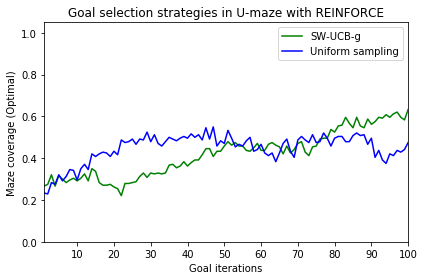

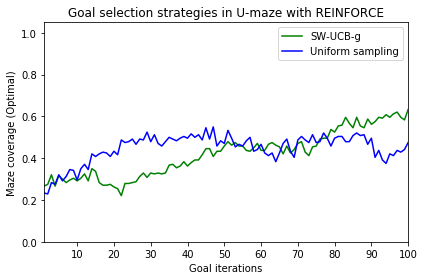

In [6]:
import numpy as np

from lagom.core.plotter import Plotter

from goal_sampler import UniformGoalSampler
from goal_sampler import RejectionGoalSampler
from goal_sampler import RejectionAstarGoalSampler
from goal_sampler import RejectionL2GoalSampler
from goal_sampler import SWUCBgGoalSampler


def get_data(IDs, logs):
    data = []
    for ID in IDs:
        d = [i['Eval']['Mean success rate'] for i in logs[('ID', ID)].values()]
        data.append(d)
        
    return data

def plotting(log_file):
    # Create a plotter
    plotter = Plotter()
    
    # Get the logging dictionary of goal selection
    logs = np.load('logs/goal_selection.npz').items()[0][1].item()['goal_selection']
    
    # Get IDs for different goal samplers, each with many random seeds
    #IDs_uniform = [logs['ID'] for logs in experiment.list_configs if logs['goal_sampler'] is UniformGoalSampler]
    #IDs_rejection = [logs['ID'] for logs in experiment.list_configs if logs['goal_sampler'] is RejectionGoalSampler]
    #IDs_rejection_astar = [logs['ID'] for logs in experiment.list_configs if logs['goal_sampler'] is RejectionAstarGoalSampler]
    #IDs_rejection_l2 = [logs['ID'] for logs in experiment.list_configs if logs['goal_sampler'] is RejectionL2GoalSampler]
    #IDs_SWUCBg = [logs['ID'] for logs in experiment.list_configs if logs['goal_sampler'] is SWUCBgGoalSampler]
       
    # Get metrics according to IDs
    #cover_uniform = get_data(IDs_uniform, logs)
    #cover_rejection = get_data(IDs_rejection, logs)
    #cover_rejection_astar = get_data(IDs_rejection_astar, logs)
    #cover_rejection_l2 = get_data(IDs_rejection_l2, logs)
    cover_SWUCBg = get_data([1], logs)
    cover_uniform = get_data([0], logs)

    # Add curves for each goal sampler
    #plotter.add_curve(cover_uniform, 
    #                  color='green', 
    #                  label='Uniform sampling', 
    #                  uncertainty=True,
    #                  scales=[0.5, 1.0],  # stds
    #                  alphas=[0.3, 0.2])  # transparency
    
    plotter.add_curve(cover_SWUCBg, 
                      color='green', 
                      label='SW-UCB-g', 
                      uncertainty=True,
                      scales=[0.5, 1.0],  # stds
                      alphas=[0.3, 0.2])  # transparency
    
    plotter.add_curve(cover_uniform, 
                      color='blue', 
                      label='Uniform sampling', 
                      uncertainty=True,
                      scales=[0.5, 1.0],  # stds
                      alphas=[0.3, 0.2])  # transparency
    
    

    title = 'Goal selection strategies in U-maze with REINFORCE'
    xlabel = 'Goal iterations'
    ylabel = 'Maze coverage (Optimal)'
    xlim = [1, len(cover_SWUCBg[0])]
    ylim = [0, 1 + 0.05]
    fig = plotter.plot(title, 
                       xlabel, 
                       ylabel, 
                       xlim=xlim, 
                       ylim=ylim, 
                       log_x=False, 
                       integer_x=True)

    return fig


fig = plotting('logs/goal_selection.npy')
fig.savefig('logs/tmp.png')

fig

# Animation of heatmaps (success coverage)

In [ ]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.patches import Rectangle

from lagom.core.plotter import Plotter

from IPython.display import HTML


fig, ax = plt.subplots(1, 1)

plotter = Plotter()

path = 'logs/ID_0_eval_uniform.npy'
info = 'Average Return over all goals'

goals = [goal for iter_num, goal in np.load(path).item()[info].keys()]
anim_data = list(np.load(path).item()[info].values())
num_data = len(anim_data)

map_size = 4

def animate(i):
    fig.clear()
    
    data = np.array(anim_data[i]).reshape([map_size, map_size])

    ax = plotter.heatmap(data, 
                         vmin=0, 
                         vmax=1, 
                         cmap='YlGnBu', 
                         annot=True, 
                         linewidths=.0, 
                         square=True, 
                         xticklabels=np.arange(1, map_size+1), 
                         yticklabels=np.arange(1, map_size+1))
    
    ax.set_title('Training iteration: {},  goal: {}'.format(i, goals[i]))
    
    ax.add_patch(Rectangle(np.array(goals[i][::-1])-1, 1, 1, fill=False, edgecolor='yellow'))

anim = animation.FuncAnimation(fig, animate, frames=num_data, interval=2000)

anim.save('tmp.gif', writer='imagemagick', fps=.5)

HTML(anim.to_html5_video())